In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import os

while "utils" not in os.listdir():
    os.chdir("..")

sns.set_context('talk')

In [2]:
def normalise_value(df: pd.DataFrame, grouping_column_list: list, metric_column: str) -> pd.DataFrame:
    """
    Normalise value using mean normalisation.
    https://en.wikipedia.org/wiki/Feature_scaling#Mean_normalization
    """
    df_agg = (
        df
        .groupby(grouping_column_list)
        .agg({
            metric_column: ["mean", "min", "max"]
        })
        .reset_index()
    )
    df_agg.columns = [
        col[0] 
        if col[1] == '' 
        else '_'.join(col) 
        for col in df_agg.columns
    ]
    display(df_agg.head())
    
    _row_before = df.shape[0]
    df = df.merge(
        df_agg,
        how="left",
        on=grouping_column_list
    )
    assert df.shape[0] == _row_before, f"Inconsistent row count after dataframe merging. Before: {_row_before}; current: {df_agg.shape[0]}"
    
    df[f"{metric_column}_normalised"] = (
        (df[metric_column] - df[f"{metric_column}_mean"]) 
        / (df[f"{metric_column}_max"] - df[f"{metric_column}_min"])
    )
    
    return df

# Data Preparation

In [3]:
df_raw = pd.read_csv("data/online_retail_II.csv")
df_raw.shape

(1067371, 8)

In [4]:
df_raw.iloc[0]

Invoice                                     489434
StockCode                                    85048
Description    15CM CHRISTMAS GLASS BALL 20 LIGHTS
Quantity                                        12
InvoiceDate                    2009-12-01 07:45:00
Price                                         6.95
Customer ID                                13085.0
Country                             United Kingdom
Name: 0, dtype: object

In [5]:
df_raw['Customer ID'] = df_raw['Customer ID'].astype(str).apply(lambda x: x.split('.')[0])
df_raw['InvoiceDate'] = pd.to_datetime(df_raw['InvoiceDate'])
df_raw['subtotal'] = df_raw['Quantity'] * df_raw['Price']

In [6]:
## to remove hour and minute, convert to a date object
df_raw['invoice_date_week'] = pd.to_datetime(
    pd.to_datetime(df_raw['InvoiceDate']) - pd.to_timedelta(df_raw['InvoiceDate'].dt.dayofweek, unit='d')
).dt.date

## convert back to datetime object, so we can use it for pd.Grouper()
df_raw['invoice_date_week'] = pd.to_datetime(df_raw['invoice_date_week'])

In [7]:
from pandas.tseries.offsets import MonthEnd

df_raw['month_end_date'] = df_raw['InvoiceDate'] + MonthEnd(1)

In [8]:
print(f"Number of unique item codes: {df_raw['StockCode'].nunique():,}")

Number of unique item codes: 5,305


In [9]:
agg_date = df_raw.groupby(['StockCode']).agg({
    'invoice_date_week': ['min','max','nunique']
}).reset_index()

agg_date.columns = [
    col[0] if col[1] == '' else col[0]+'_'+col[1] for col in agg_date.columns
]

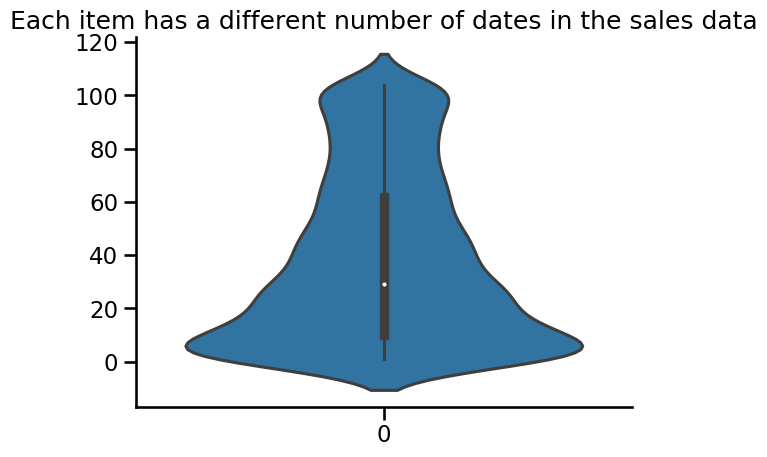

In [10]:
sns.violinplot(agg_date['invoice_date_week_nunique'])
plt.title('Each item has a different number of dates in the sales data')
sns.despine();

In [11]:
df_raw['Quantity'].describe()

count    1.067371e+06
mean     9.938898e+00
std      1.727058e+02
min     -8.099500e+04
25%      1.000000e+00
50%      3.000000e+00
75%      1.000000e+01
max      8.099500e+04
Name: Quantity, dtype: float64

In [12]:
negative_quantity = (df_raw['Quantity'] < 0).sum() / df_raw.shape[0] 
print(f"{negative_quantity:.2%} of the records have negative sales quantity")

2.15% of the records have negative sales quantity


Interesting -- the total sales quantity can be extremely negative. To simplify, we'll only take items with positive all-time sales quantity.

In [13]:
agg_quantity = df_raw.groupby('StockCode')['Quantity'].sum().sort_values().reset_index()
agg_quantity.head()

,StockCode,Quantity
0,20852,-18800
1,22126,-16400
2,23005,-14418
3,23003,-8516
4,10120,-8350


In [14]:
positive_quantity_item_list = agg_quantity.query('Quantity > 0')['StockCode'].tolist()
df_selected = df_raw.query('StockCode in @positive_quantity_item_list')

# Observe sales history

In [15]:
df_selected.iloc[0]

Invoice                                           489434
StockCode                                          85048
Description          15CM CHRISTMAS GLASS BALL 20 LIGHTS
Quantity                                              12
InvoiceDate                          2009-12-01 07:45:00
Price                                               6.95
Customer ID                                        13085
Country                                   United Kingdom
subtotal                                            83.4
invoice_date_week                    2009-11-30 00:00:00
month_end_date                       2009-12-31 07:45:00
Name: 0, dtype: object

In [16]:
df_agg = df_selected.groupby([
    pd.Grouper(
        key='invoice_date_week',
        freq='W'
    ),
    'StockCode'
])['Quantity'].sum().reset_index().rename(
    columns={
        'StockCode': 'stock_code',
        'Quantity': 'quantity'
    }
)

df_agg.head()

,invoice_date_week,stock_code,quantity
0,2009-12-06,10002,141
1,2009-12-06,10002R,1
2,2009-12-06,10080,4
3,2009-12-06,10123C,4
4,2009-12-06,10123G,2


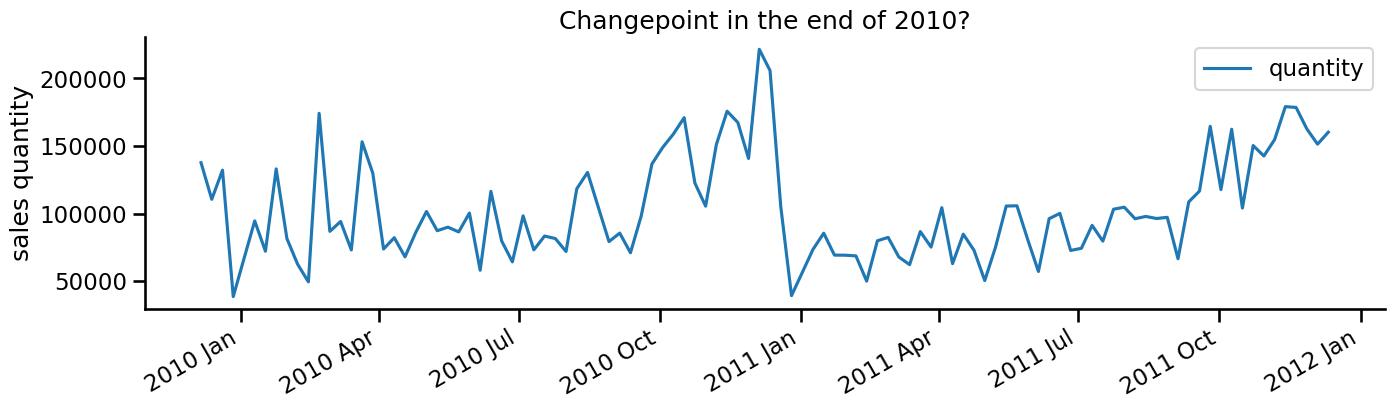

In [17]:
f, ax = plt.subplots(figsize=(16, 4))

_df = df_agg.groupby('invoice_date_week')['quantity'].sum().reset_index()

_df.plot(
    x='invoice_date_week',
    y='quantity',
    ax=ax,
    kind='line'
)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
ax.set_xlabel('')
ax.set_ylabel('sales quantity')
plt.title("Changepoint in the end of 2010?")
sns.despine();

## Generate complete time series

In [18]:
from utils.preprocess_time_series import generate_complete_records

GENERATE_SERIES = False
SERIES_FILE_NAME = 'data/weekly-item-full-series.parquet'

if GENERATE_SERIES:
    df_agg_full = generate_complete_records(df=df_agg, date_freq='W')    
    df_agg_full.to_parquet(SERIES_FILE_NAME)
else:
    df_agg_full = pd.read_parquet(SERIES_FILE_NAME)
    
assert df_agg_full['quantity'].sum() == df_agg['quantity'].sum(), "Different values after generating complete records!"

In [19]:
df_agg_full = normalise_value(df=df_agg_full, grouping_column_list=["stock_code"], metric_column="quantity")
df_agg_full.head()

,stock_code,quantity_mean,quantity_min,quantity_max
0,10002,73.490566,-116.0,747.0
1,10002R,0.037736,0.0,2.0
2,10080,5.632075,0.0,182.0
3,10123C,3.547170,-18.0,124.0
4,10123G,11.245283,-38.0,1187.0


,invoice_date_week,stock_code,quantity,quantity_mean,quantity_min,quantity_max,quantity_normalised
0,2009-12-06,10002,141.0,73.490566,-116.0,747.0,0.078226
1,2009-12-13,10002,24.0,73.490566,-116.0,747.0,-0.057347
2,2009-12-20,10002,37.0,73.490566,-116.0,747.0,-0.042283
3,2009-12-27,10002,14.0,73.490566,-116.0,747.0,-0.068935
4,2010-01-03,10002,0.0,73.490566,-116.0,747.0,-0.085157


In [20]:
mask = (df_agg_full['stock_code'] == '10002')
df_agg_full[mask]

,invoice_date_week,stock_code,quantity,quantity_mean,quantity_min,quantity_max,quantity_normalised
0,2009-12-06,10002,141.0,73.490566,-116.0,747.0,0.078226
1,2009-12-13,10002,24.0,73.490566,-116.0,747.0,-0.057347
2,2009-12-20,10002,37.0,73.490566,-116.0,747.0,-0.042283
3,2009-12-27,10002,14.0,73.490566,-116.0,747.0,-0.068935
4,2010-01-03,10002,0.0,73.490566,-116.0,747.0,-0.085157
...,...,...,...,...,...,...,...
101,2011-11-13,10002,0.0,73.490566,-116.0,747.0,-0.085157
102,2011-11-20,10002,0.0,73.490566,-116.0,747.0,-0.085157
103,2011-11-27,10002,0.0,73.490566,-116.0,747.0,-0.085157
104,2011-12-04,10002,0.0,73.490566,-116.0,747.0,-0.085157


In [21]:
# verify if the ts is complete
_df = df_agg_full.groupby(["stock_code"]).agg({
    "invoice_date_week": ["min","max","count"]
}).reset_index()

_df.columns = [
    col[0] if col[1] == '' else '_'.join(col) 
    for col in _df.columns
]
_df["invoice_date_week_diff"] = (_df["invoice_date_week_max"] - _df["invoice_date_week_min"]) / np.timedelta64(1, 'W')

_check = ((_df["invoice_date_week_diff"] - 1) == _df["invoice_date_week_count"]).sum()
assert _check == 0, "There are missing period in the time series data!"

## Observe new time series data

In [22]:
agg_quantity.tail()

,StockCode,Quantity
5300,84879,80705
5301,21212,95450
5302,85099B,95739
5303,85123A,96066
5304,84077,108545


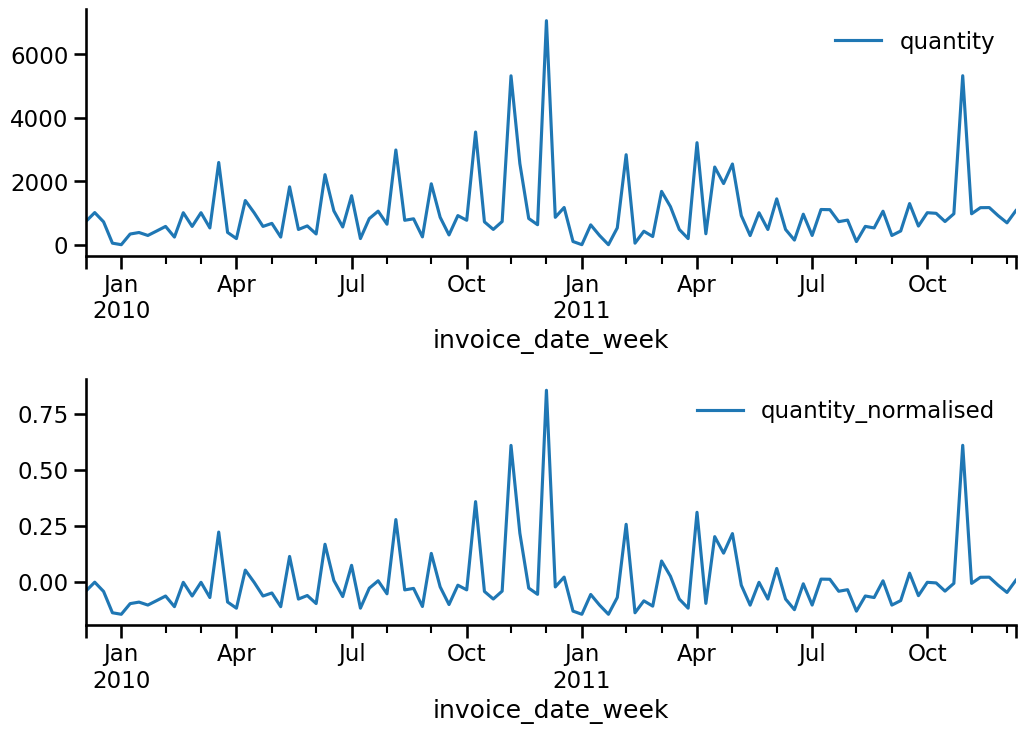

In [23]:
f, ax = plt.subplots(figsize=(12,8), nrows=2)
plt.subplots_adjust(hspace=.5)

SELECTED_ITEM = '84077'
for idx, metric in enumerate(["quantity", "quantity_normalised"]):
    df_agg_full.query('stock_code == @SELECTED_ITEM').plot.line(
        x='invoice_date_week', 
        y=metric, 
        label=metric,
        ax=ax[idx]
    );
    ax[idx].legend(frameon=False)

sns.despine();

# Clustering

Use autoencoders to retrieve the latent representation of the time series, then run clustering algorithms.

In [24]:
!pip install keras tensorflow graphviz pydot umap-learn -q

In [25]:
df_agg_pivot = df_agg_full.pivot_table(
    index='stock_code',
    columns='invoice_date_week',
    values='quantity_normalised', # 'quantity'
    fill_value=0
)
df_agg_pivot.head()

invoice_date_week,2009-12-06,2009-12-13,2009-12-20,2009-12-27,2010-01-03,2010-01-10,2010-01-17,2010-01-24,2010-01-31,2010-02-07,...,2011-10-09,2011-10-16,2011-10-23,2011-10-30,2011-11-06,2011-11-13,2011-11-20,2011-11-27,2011-12-04,2011-12-11
stock_code,,,,,,,,,,,,,,,,,,,,,
10002,0.078226,-0.057347,-0.042283,-0.068935,-0.085157,-0.067776,0.136164,-0.037648,-0.034172,-0.066617,...,-0.085157,-0.085157,-0.085157,-0.085157,-0.085157,-0.085157,-0.085157,-0.085157,-0.085157,-0.085157
10002R,0.481132,-0.018868,0.981132,-0.018868,-0.018868,-0.018868,-0.018868,-0.018868,0.481132,-0.018868,...,-0.018868,-0.018868,-0.018868,-0.018868,-0.018868,-0.018868,-0.018868,-0.018868,-0.018868,-0.018868
10080,-0.008967,-0.030945,-0.030945,-0.030945,-0.030945,-0.030945,-0.030945,-0.030945,-0.030945,-0.030945,...,-0.030945,-0.008967,-0.030945,-0.019956,0.100923,0.221802,0.056967,0.117406,-0.030945,-0.030945
10123C,0.003189,0.087696,0.848259,-0.024980,-0.024980,-0.024980,-0.003853,0.066569,0.073611,-0.067234,...,-0.024980,-0.024980,-0.024980,-0.024980,-0.024980,-0.024980,-0.024980,-0.024980,-0.024980,-0.024980
10123G,-0.007547,-0.009180,-0.009180,-0.009180,-0.009180,-0.009180,-0.009180,-0.009180,-0.009180,-0.009180,...,-0.009180,-0.009180,-0.009180,-0.009180,-0.009180,-0.009180,-0.009180,-0.009180,-0.009180,-0.009180


In [26]:
df_agg_pivot.values

array([[ 0.07822646, -0.05734712, -0.04228339, ..., -0.08515709,
        -0.08515709, -0.08515709],
       [ 0.48113208, -0.01886792,  0.98113208, ..., -0.01886792,
        -0.01886792, -0.01886792],
       [-0.00896745, -0.03094547, -0.03094547, ...,  0.11740618,
        -0.03094547, -0.03094547],
       ...,
       [ 0.        ,  0.        ,  0.26223776, ..., -0.01048951,
        -0.01048951, -0.01048951],
       [ 0.        ,  0.        ,  0.        , ..., -0.0122449 ,
        -0.0122449 , -0.0122449 ],
       [ 0.        ,  0.        ,  0.        , ..., -0.02631579,
        -0.02631579, -0.02631579]])

In [27]:
df_agg_pivot.shape

(4710, 106)

In [28]:
# Reference: 
# https://machinelearningmastery.com/lstm-autoencoders/
# https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352
# Try reducing the dimensions via autoencoder

# lstm autoencoder recreate sequence
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model

# define input sequence
USE_SUBSET = True
if USE_SUBSET:
    input_sequence = df_agg_pivot.values[:500]
else:
    input_sequence = df_agg_pivot.values
    
# reshape input into [samples, timesteps, features]
n_sample = len(input_sequence)
n_input_seq = df_agg_pivot.shape[1]
sequence = input_sequence.reshape((n_sample, n_input_seq, 1))

# define model
model = Sequential()
model.add(LSTM(128, activation='softmax', input_shape=(n_input_seq, 1), return_sequences=True))
model.add(LSTM(64, activation='softmax', return_sequences=False))
model.add(RepeatVector(n_input_seq))
model.add(LSTM(64, activation='softmax', return_sequences=True))
model.add(LSTM(128, activation='softmax', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(sequence, sequence, epochs=30, batch_size=10, verbose=0)

# connect the encoder LSTM as the output layer
# model = Model(inputs=model.inputs, outputs=model.layers[0].output)
plot_model(model, show_shapes=True, to_file='report/lstm_encoder.png')
# print(model.summary())

# get the feature vector for the input sequence
yhat = model.predict(sequence, verbose=0)

print(yhat.shape)
print(yhat)

2023-11-19 20:14:57.249656: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 20:14:57.249708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 20:14:57.250822: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-19 20:14:57.256954: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 20:14:59.119870: W tensorflow/compiler/tf2

(500, 106, 1)
[[[ 1.1152704e-03]
  [ 6.2740617e-04]
  [ 5.2884221e-04]
  ...
  [-5.3564319e-05]
  [-5.3564319e-05]
  [-5.3564319e-05]]

 [[ 1.1152704e-03]
  [ 6.2740617e-04]
  [ 5.2884221e-04]
  ...
  [-5.3564319e-05]
  [-5.3564319e-05]
  [-5.3564319e-05]]

 [[ 1.1152704e-03]
  [ 6.2740617e-04]
  [ 5.2884221e-04]
  ...
  [-5.3564319e-05]
  [-5.3564319e-05]
  [-5.3564319e-05]]

 ...

 [[ 1.1152704e-03]
  [ 6.2740617e-04]
  [ 5.2884221e-04]
  ...
  [-5.3564319e-05]
  [-5.3564319e-05]
  [-5.3564319e-05]]

 [[ 1.1152700e-03]
  [ 6.2740617e-04]
  [ 5.2884221e-04]
  ...
  [-5.3564319e-05]
  [-5.3564319e-05]
  [-5.3564319e-05]]

 [[ 1.1152700e-03]
  [ 6.2740617e-04]
  [ 5.2884221e-04]
  ...
  [-5.3564319e-05]
  [-5.3564319e-05]
  [-5.3564319e-05]]]


In [29]:
yhat.shape

(500, 106, 1)

Try reducing the dimensions of the latent representation using UMAP to see if it forms clusters.

In [63]:
yhat.reshape(
        (yhat.shape[0], yhat.shape[1])
    ).shape

(500, 106)

In [78]:
# further reading - alignedumap
# https://umap-learn.readthedocs.io/en/latest/aligned_umap_politics_demo.html

import umap

embedding = umap.UMAP(
    n_neighbors=10,
    min_dist=0.2,
    n_components=2,
    random_state=121,
).fit_transform(
    yhat.reshape(
        (yhat.shape[0], yhat.shape[1])
    )
)

df_umap = pd.DataFrame(data={
    'x': embedding[0:,0],
    'y': embedding[0:,1],
    'stock_code': df_agg_pivot[:n_sample].index,
})

df_umap.head()

/mnt/sda2/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


,x,y,stock_code
0,14.064734,1.883816,10002
1,13.205820,2.909240,10002R
2,14.020049,1.589351,10080
3,13.586078,3.282736,10123C
4,14.206782,1.615500,10123G


/mnt/sda2/miniconda3/lib/python3.11/site-packages/seaborn/_core/rules.py:72: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/sda2/miniconda3/lib/python3.11/site-packages/seaborn/_core/rules.py:72: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/sda2/miniconda3/lib/python3.11/site-packages/seaborn/_core/plot.py:1491: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):


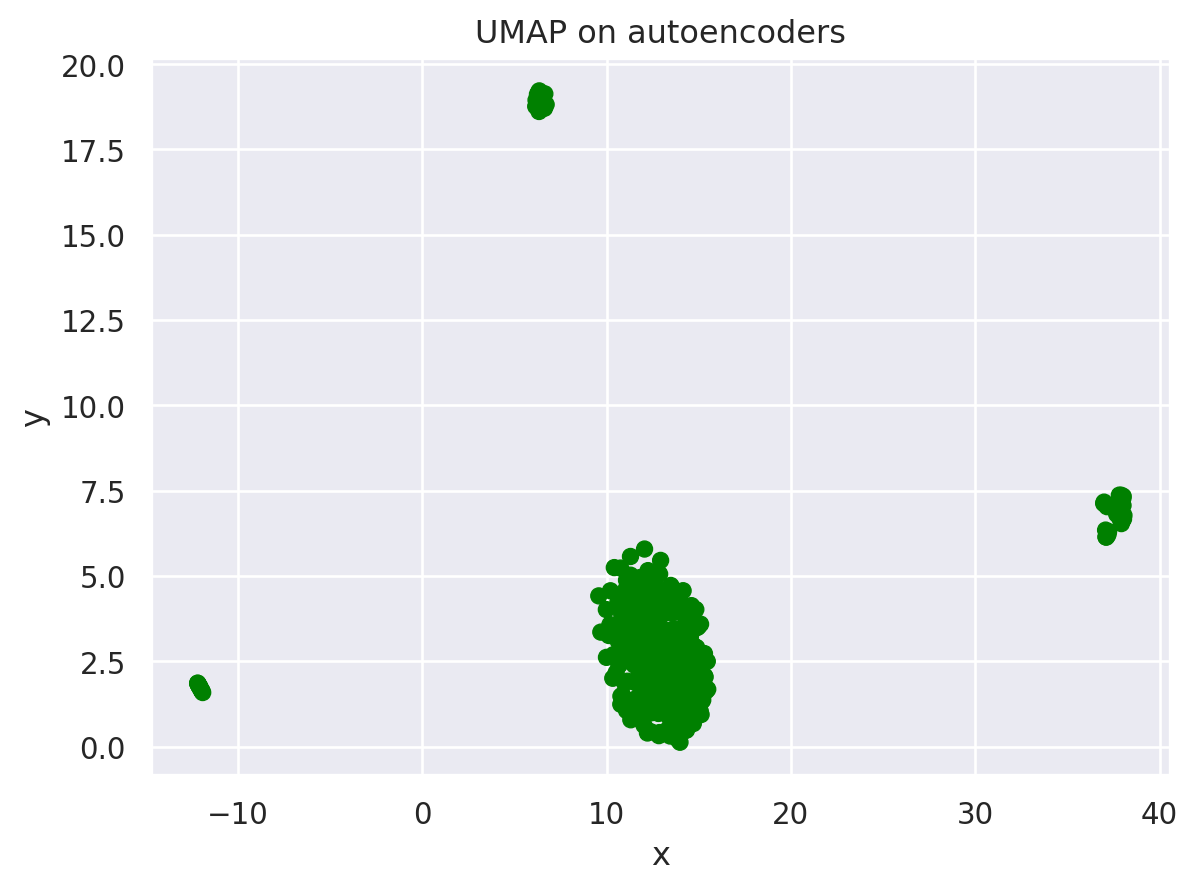

In [79]:
import seaborn.objects as so

plot = (
    so.Plot(
        data=df_umap, x='x', y='y'
    )
    .add(so.Dot(color="green"))
    .label(x='x', y='y', title='UMAP on autoencoders')
)

plot

In [83]:
# inspect one of the blob
mask = (
    (df_umap['x'] >= 10)
    & (df_umap['y'] < 5)
)

df_umap[mask].sample(5)

,x,y,stock_code
169,13.575274,3.404099,20619
329,14.290293,0.474126,20861
145,13.523396,1.897156,17109C
454,13.484426,4.721351,21063
482,12.616449,4.010097,21099


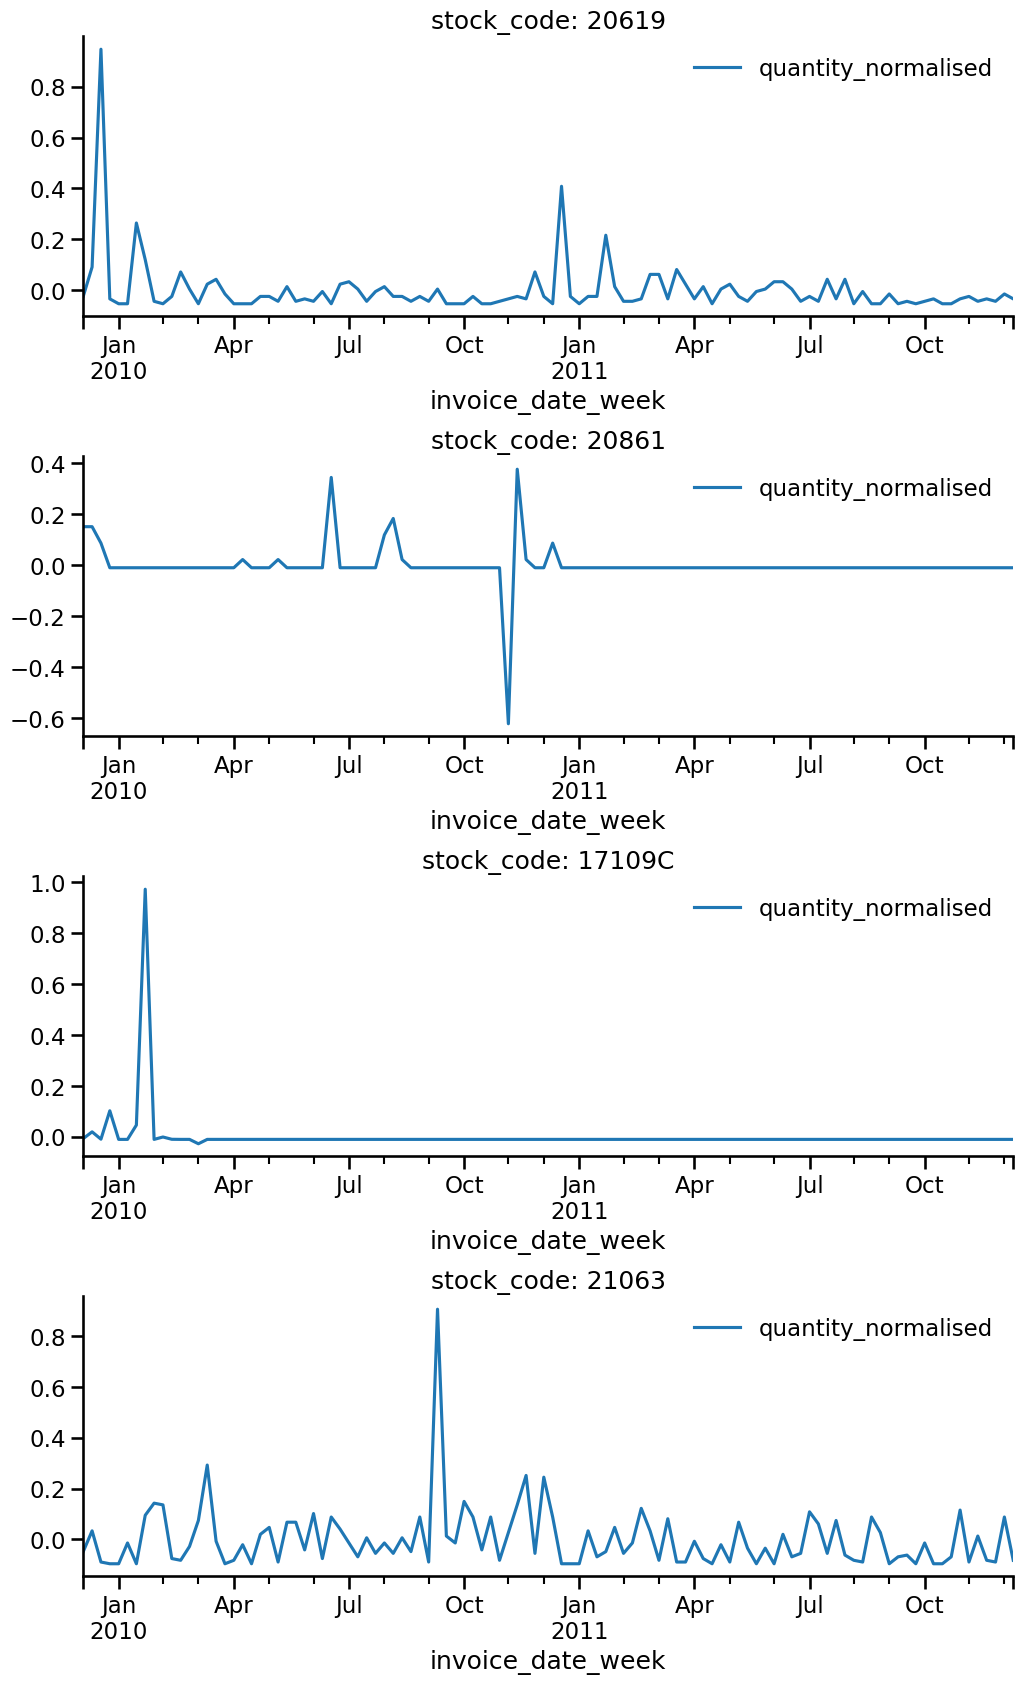

In [84]:
selected_item_list = ['20619','20861','17109C','21063']
metric = 'quantity_normalised'

f, ax = plt.subplots(figsize=(12, 20), nrows=4)
plt.subplots_adjust(hspace=.5)

for idx, item in enumerate(selected_item_list):
    df_agg_full.query('stock_code == @item').plot.line(
        x='invoice_date_week', 
        y=metric, 
        label=metric,
        ax=ax[idx]
    );
    ax[idx].set_title(f"stock_code: {item}")
    ax[idx].legend(frameon=False)

sns.despine();

Comparison: UMAP on the normalised quantity.

In [59]:
input_sequence.shape

(500, 106)

In [85]:
import umap

embedding = umap.UMAP(
    n_neighbors=10,
    min_dist=0.2,
    n_components=2,
    random_state=121,
).fit_transform(
    input_sequence
)

df_umap_b = pd.DataFrame(data={
    'x': embedding[0:,0],
    'y': embedding[0:,1],
    'stock_code': df_agg_pivot[:n_sample].index,
})

df_umap_b.head()

/mnt/sda2/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


,x,y,stock_code
0,12.942795,0.687115,10002
1,15.694569,2.692427,10002R
2,12.331431,-1.830868,10080
3,15.929113,2.569473,10123C
4,3.705003,1.613274,10123G


/mnt/sda2/miniconda3/lib/python3.11/site-packages/seaborn/_core/rules.py:72: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/sda2/miniconda3/lib/python3.11/site-packages/seaborn/_core/rules.py:72: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/sda2/miniconda3/lib/python3.11/site-packages/seaborn/_core/plot.py:1491: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):


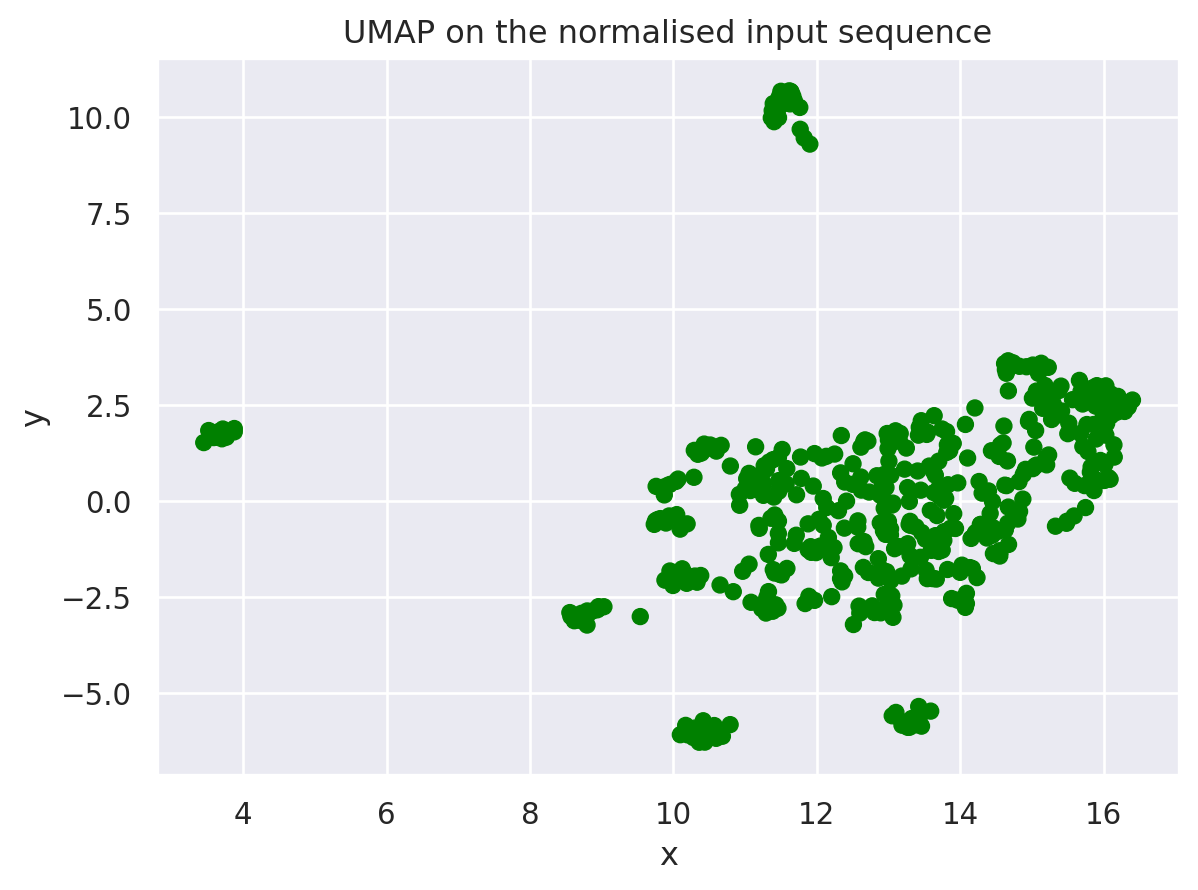

In [86]:
import seaborn.objects as so

plot = (
    so.Plot(
        data=df_umap_b, x='x', y='y'
    )
    .add(so.Dot(color="green"))
    .label(x='x', y='y', title='UMAP on the normalised input sequence')
)

plot